In [1]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math

img_w = 64
img_h = 128
nbins = 9
cell_w_h = 8

cells_grid_columns = int(img_w/cell_w_h)
cells_grid_rows = int(img_h/cell_w_h)

(128, 64) <class 'numpy.ndarray'>


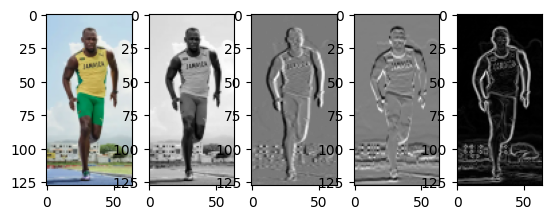

In [30]:
img_path = os.path.join(".","bolt_test_HOG.png")
color_img = cv2.imread(img_path)
color_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
print(img.shape, type(img))

img = np.float32(img) / 255.0
gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)

mag, angles = cv2.cartToPolar(gx,gy, angleInDegrees=True)

fig, ax = plt.subplots(nrows=1, ncols=5)
ax[0].imshow(color_img, )
ax[1].imshow(img, cmap='gray',)
ax[2].imshow(gx, cmap='gray')
ax[3].imshow(gy, cmap='gray')
ax[4].imshow(mag, cmap='gray')
plt.show()

In [36]:
def ToBins(cell_dir:np.array, cell_mag:np.array):
    #direction angles in degrees!
    assert cell_dir.shape == cell_mag.shape, f"dir {cell_dir.shape} and mag {cell_mag.shape} matrixes have a different shape."

    if cell_dir.ndim == 2:
        cell_dir = cell_dir[:,:,np.newaxis]
        cell_mag = cell_mag[:,:,np.newaxis]

    cell_dir = cell_dir % 180
    bins = np.zeros(shape=(nbins,cell_dir.shape[-1]), dtype=np.float32)
    step = 180.0/nbins
    
    #in this array, idx 0 correspond to angle 180-step, and idx -1 correspond to angle 0
    angles = np.arange(-step,180.0+step,step)
    angles = angles[:,np.newaxis]   #for broadcasting

    idx_helper = np.arange(cell_dir.shape[-1])
    #print(angles)
    for i in range(cell_w_h):
        for j in range(cell_w_h):
            dir, mag = cell_dir[i,j], cell_mag[i,j]
            diff = np.abs(angles-dir)
            idx_1 = np.argmin(diff, 0)
            idx_3 = np.argmin(diff, 0, keepdims=True)
            tmp = diff[idx_1, idx_helper]
            diff[idx_1, idx_helper] = 180
            idx_2 = np.argmin(diff, 0)

            #print(diff,idx_1,tmp, idx_2)
            diff[idx_1, idx_helper] = tmp

            #print("idx1: ",diff[idx_1] / step,"\nidx2: ", diff[idx_2] / step)


            factor_1 = 1.0 - diff[idx_1, idx_helper] / step
            factor_2 = 1.0 - diff[idx_2, idx_helper] / step
            assert np.all(factor_1 >= 0), print(factor_1)
            assert np.all(factor_2 >= 0), print(diff,idx_1,idx_2,factor_2)
            #now we just have to correct the indexes.
            idx_1 = np.where(idx_1==0, nbins-1, idx_1-1)
            idx_1 = np.where(idx_1==nbins, 0, idx_1)
            idx_2 = np.where(idx_2==0, nbins-1, idx_2-1)
            idx_2 = np.where(idx_2==nbins, 0, idx_2)
            bins[idx_1] = bins[idx_1] + factor_1 * mag
            bins[idx_2] = bins[idx_2] + factor_2 * mag
    return bins

def normalize(v:np.array):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

assert np.all(mag>=0), "Not all mags are >= 0."

hogs = np.empty([cells_grid_rows, cells_grid_columns, nbins,3], dtype=np.float32)
for i in range(cells_grid_rows):
    for j in range(cells_grid_columns):
       hogs[i,j] = ToBins(angles[i:i+8, j:j+8],mag[i:i+8, j:j+8])

assert np.all(hogs>=0), "Not all hog values are >= 0."

norm_hogs = np.empty([cells_grid_rows-1, cells_grid_columns-1, nbins,3], dtype=np.float32)
#let's create the norm matrix (15x7) --> 4 cells normalized in one block = 16x16 pixel block normalization
for i in range(cells_grid_rows-1):
    for j in range(cells_grid_columns-1):
        norm_hogs[i,j] = normalize(hogs[i:i+1,j:j+1])


[  0.  15.  30.  45.  60.  75.  90. 105. 120. 135. 150. 165.] 
 [0.08007693 0.00393359 0.94903755 0.94151897 0.05984645 0.85317922
 0.34710486 0.98509882 0.39155049 0.17967733 0.66134858 0.18290967]


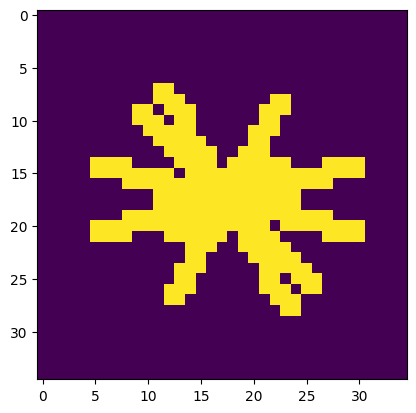

In [40]:
#visualization

def PlotAngles(angles:np.array, mags:np.array, thickness:int=1, plot_dim=35):
    assert plot_dim > 1, "plot_dimf must be greater than 1."
    assert thickness >= 1, "thickness must be greater then 0."
    assert angles.dtype is not np.float32 , f"dtype for tensor angles must be float32, but it's {angles.dtype}"
    assert mags.dtype is not np.float32 , f"dtype for tensor mags must be float32, but it's {mags.dtype}"
    assert mags.shape == angles.shape, f"tensor mags {mags.shape} has a different shape respect {angles.shape}"
    assert np.all(mags >= 0) and np.all(mags <= 1), f"mag's value should be between 0 and 1. You passed {mags}"
    margin = int(plot_dim/8)

    plot_matrix = np.zeros(shape=(plot_dim,plot_dim), dtype=np.uint8)
    #print(plot_matrix.shape)
    angles = angles*math.pi / 180.0
    dir = np.array([ -np.cos(angles), -np.sin(angles) ])
    cy = cx = round(plot_dim/2)

    boost_magnitudes = True
    mags = np.sqrt(mags) if boost_magnitudes else mags

    #let's avoid negative lenghts
    lenghts = np.maximum(np.ceil(mags * plot_dim/2) -math.floor(thickness/2) - margin, 0)
    w1 = math.ceil(thickness/2)
    w2 = thickness - w1

    #let's iterate on the maximum number of pixels which could be written.
    for i in range( math.ceil(plot_dim/2) -math.floor(thickness/2) - margin):
        mov =  np.round(dir * i).astype(np.int16)
        dx_vec = mov[0,:]
        dy_vec = mov[1,:]

        for j in range(dx_vec.shape[0]): #probably this coudl be avoided and optimized..
            dx = dx_vec[j]
            dy = dy_vec[j]
            if(lenghts[j] >= i):
                plot_matrix[cx+dx-w1:cx+dx+w2,cy+dy-w1:cy+dy+w2] = 1
                plot_matrix[cx-dx-w1:cx-dx+w2,cy-dy-w1:cy-dy+w2] = 1
    return plot_matrix


#test 
test_angles= np.arange(0,180,15, dtype=np.float32)
test_mags = np.random.random(size = test_angles.shape)
#test_mags = np.random.random(size = test_angles.shape)
#test_mags = np.ones(shape=test_angles.shape, dtype=np.float32)

mat = PlotAngles(test_angles,test_mags, thickness=2)

print(test_angles,"\n",test_mags)
plt.imshow(mat)

#before nparrays time was 1.1s


(525, 245, 3)


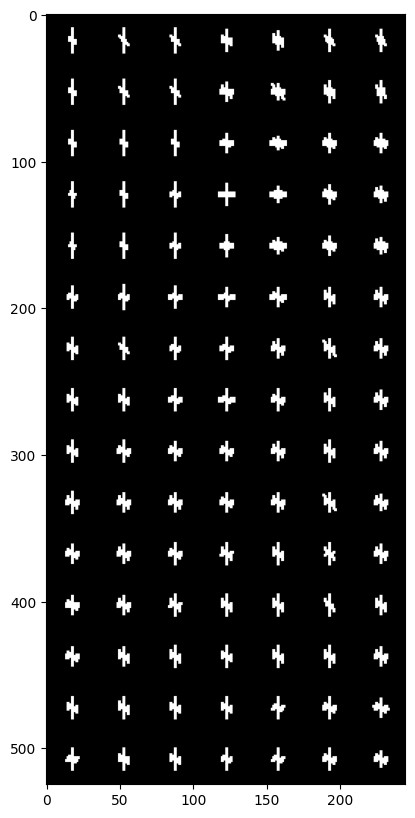

In [38]:
#visualize a full histogram
def DrawHistograms(histogram:np.array, plot_dim:int, thick=1):
    step = 180.0/nbins
    angles = np.arange(0,180,step)
    img = np.empty(shape=(plot_dim,plot_dim,histogram.shape[-1]))
    for i in range(histogram.shape[-1]):
        img[:,:,i] = PlotAngles(angles,histogram[:,i], thickness=thick, plot_dim=plot_dim) *255
    return img

#test
#print(norm_hogs[0,0,:,0])
#img = DrawHistograms(norm_hogs[0,0,:,0],35, thick=2)
#plt.imshow(img)

def Get_HOG_Graphics(hogs:np.array,thick=1):
    plot_dim = 35
    image = np.empty(shape=(hogs.shape[0]*plot_dim, hogs.shape[1]*plot_dim, hogs.shape[-1]), dtype=np.uint8)
    #red_image = np.empty(shape=(1*plot_dim, 1*plot_dim))

    for i in range(hogs.shape[0]):
        for j in range(hogs.shape[1]):
            image[i*plot_dim:(i+1)*plot_dim, j*plot_dim:(j+1)*plot_dim] = DrawHistograms(hogs[i,j], plot_dim, thick=2)
    return image

img = Get_HOG_Graphics(norm_hogs)
print(img.shape)
plt.figure(figsize = (10,10))
plt.imshow(img)